# Lab on Bandit Algorithms

Author: Claire Vernade (claire.vernade@uni-tuebingen.de)


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from random import random
colors = sns.color_palette('colorblind')

## Plot function

In [2]:
def plot_regret(regrets, logscale=False, lb=None,q=10):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    #compute useful stats
#     regret_stats = {}
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    reg_plot.show()

## First step : the Bandit environment
We have bandit environment is a very simple RL environment:
* There is only 1 state: this means actions do not imply change of state
* There are K actions
* The reward function are only action-dependent

### Can you implement such class, inheriting from the Environment mother class used in previous practical sessions ?

In [4]:
class Bandit:

    def __init__(self, means, model = 'gaussian', var=1.):
        self.model = model
        self.K = np.size(means)
        self.means = means
        self.var = var

    def get_reward(self, action):

        """ sample reward given action and the model of this bandit environment"""
        if self.model == 'gaussian':
            rnd_rew = np.random.normal(self.means[action], scale = self.var)
            mean_rew = self.means[action]
            return  rnd_rew, mean_rew
        else:#add bernoulli model option
            mean_rew = self.means[action]
            rnd_rew = float(random() <self.mean[action])
            return rnd_rew, mean_rew

### Remarks / Questions:
* The bandit environment is characterized by the family of distributions of the actions, here controlled by the keyword "model";
* Building this environment, we assumed that the models admissible are parametrized by their mean *only*. Note in particular that the experimenter needs to fix the variance of the Gaussian for all arms (here with only one value, but there could be one value per arm as long as these values are known and fixed). Keep in mind that the variance is known, it is important in the construction of UCB and Thompson Sampling later.
* It will be useful for the rest of this session to be able to sample binary rewards. Can you implement a new model option 'bernoulli' and the according reward sampling function ?

## Second step: Bandit agents
We have seen in class a variety of bandit algorithms, ranging from the most simple policies ($\epsilon$-greedy,...) to the (near-)optimal UCB. But so far we only gave *theoretical* guarantees, that hold under a set of hypotheses... note also the heavy usage of big-O notations in those theorems: this means there are hidden constants everywhere!  *It is always a good scientific practice to empirically validate the theoretical claims*, so we are going to do just that :)

For that purpose we need a few more things:
* Bandit agents, which shall inherit from the Agent class: we will implement $\epsilon$-greedy, Explore-Then-Commit and UCB,
* We recommend that you start with $\epsilon$-greedy and test it using Section 3 before moving on to more complex agents.

In [5]:
class EpsGreedy:

    def __init__(self, K, epsilon):
        """
        instantiate the agent using only the available information from the environment (i.e. not the means)
        => environment only provides K (number of available actions) here.
        """
        self.epsilon = epsilon
        self.K = K
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0

    def get_action(self):
      #initialization
        if self.t < self.K:
            action = self.t
            self.t +=1
            self.count_actions[action] += 1
            return action

        else:
            empirical_means = self.count_rewards / self.count_actions ## WARNING !

            expl = np.random.random()

            if expl < self.epsilon:

                action = np.random.randint(0,high=self.K)

            else:
                action = np.argmax(empirical_means)

            self.count_actions[action] += 1
            self.t += 1
            return action

    def receive_reward(self, action, reward):
        self.count_rewards[action] += reward

    def reset(self):
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0

    def name(self):
        return 'eps-greedy('+str(self.epsilon)+')'


class ETC:

    def __init__(self, K, m):
        " instantiate the agent using only the available information from the environment (i.e. not the means)"
        self.m = m
        self.K = K
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.commit = 0
        self.t = 0

    def get_action(self):
        ## TODO: implement ETC
        if self.t < self.m * self.K:
          action = np.random.randint(0,high=self.K)
          self.t += 1
          self.count_actions[action] += 1
          return action
        if self.t == self.m * self.K:
          empirical_means = self.count_rewards / self.count_actions
          self.commit = np.argmax(empirical_means)
          action = self.commit
          return action
        else:
          return self. commit
          # do NOT update the arm-dependent stats



    def receive_reward(self, action, reward):
        # EDIT HERE, for now it does nothing
        if self.t < self.m * self.K:
          self.count_rewards[action] += reward
        else:
          pass #do NOT update arm-dependent stats


    def reset(self):
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0

    def name(self):
        return 'ETC('+str(self.m)+')'


class UCB:
    def __init__(self, K, var, delta, T):
        self.K = K
        self.var = var
        self.delta = delta
        self.T = T
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0

    def get_action(self):
        ## TODO: Implement UCB
        if self.t < self.K:
          action = self.t
        else:
          empirical_means = self.count_rewards / self.count_actions
          ucbs = np.sqrt(2 * self.var * np.log(self.T/self.delta) / self.count_actions)
          # action = np.random.randint(0,high=self.K)
          action = np.argmax(empirical_means + ucbs)

        self.t += 1
        self.count_actions[action] += 1
        return action

    def receive_reward(self, action, reward):
        self.count_rewards[action] += reward

    def reset(self):
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0

    def name(self):
        return 'UCB('+str(self.delta)+','+str(self.var)+')'


## Third Step: Play !
We have an environment and a policy, we now must make them play together and collect the data so that we can observe the results.

###The role of the input ``Nmc`` in the ``play`` function:
The theorems that bound the regret are either in expectation or with high probability, so to validate them empirically, we need to observe *more than one game*. This is a very important part of these experiments: we want to build a _monte-carlo estimator of the regret_, which plays several games and allows us to observe some statistics of all trajectories. This will allow us to control that the regret does not "explode" once in a while, and that the *expectation* over the various sources of randomness (agent and environment) is under control.
Long story short: the more you run trajectories, the better is your estimate of the regret and the more meaningful are your error bars :)

### Building a game player, with regret loader:
* We want to play a T-step game (horizon T) between an environment and an agent
* We want to record the regret of our agent at every step (the agent does *not* see this!)
* We want to be able to compare agents on a fixed environment

In [5]:
def play(environment, agent, Nmc, T):

    data = np.zeros((Nmc, T))
    best_reward = np.max(environment.means)
#     print(best_reward)

    for n in range(Nmc):
        agent.reset()
        for t in range(T):

            action = agent.get_action()
#             print('action'+str(action))
            reward, mean_reward = environment.get_reward(action)
            agent.receive_reward(action,reward)
            # print(reward)
            data[n,t]= best_reward - mean_reward #optimize: store only every X steps

    return agent.name(), data


def experiment(environment, agents, Nmc, T):

    all_data = {}

    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T)

        all_data[agent_id] = regrets

    return all_data

## Observe the results and make critical observations

We are now ready to run an experiment and observe the results


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_19635/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


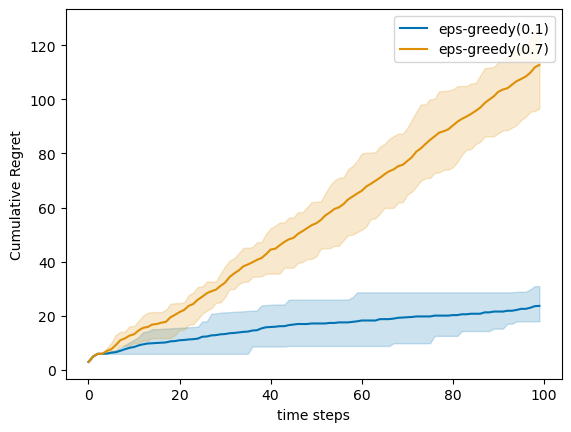

In [6]:
means = np.array([0., 1., 2., 3.])
K=len(means)
basicGaussianBandit = Bandit(means)
epsgreedy01 = EpsGreedy(K, epsilon=0.1)
epsgreedy07 = EpsGreedy(K, epsilon=0.7)

firstregrets = experiment(basicGaussianBandit, [epsgreedy01, epsgreedy07], Nmc=10, T=100)

plot_regret(firstregrets)

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_19635/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


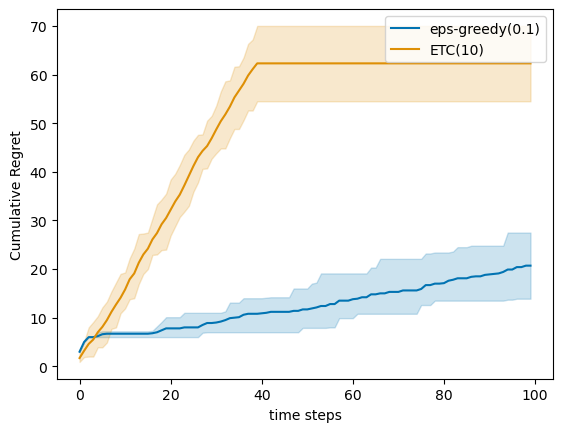

In [7]:
means = np.array([0., 1., 2., 3.])
K=len(means)
small_var_GaussianBandit = Bandit(means, var=0.5)
agent1 = EpsGreedy(K, epsilon=0.1)
agent2 = ETC(K, m=10)

regrets_small_var = experiment(small_var_GaussianBandit, [agent1, agent2], Nmc=10, T=100)
plot_regret(regrets_small_var)

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_19635/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


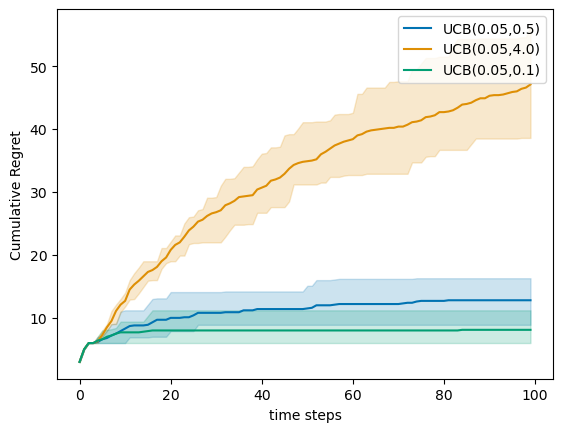

In [8]:
UCB_exact = UCB(K, var=0.5, delta=0.05, T=100)
badUCB = UCB(K, var=4., delta=0.05, T=100)
lowvarUCB = UCB(K, var=0.1, delta=0.05, T=100)

regrets_UCBs = experiment(basicGaussianBandit, [UCB_exact, badUCB, lowvarUCB], Nmc=10, T=100)
plot_regret(regrets_UCBs)

### Critical observations:
* Does it seem right ? Remember that we are trying to validate theory so we should be able to check that the theorem is true. If not... two options: our code has a bug or our theorem proof has a bug :S (or hypotheses are violated).
* What is the shape of the regret ? Do you think this policy is consistent ? Optimal ? How could you check ?
* Which policy is the best? Is it statistically significant ?
* Can we do better ? (see Step 5 for more)



/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_19635/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


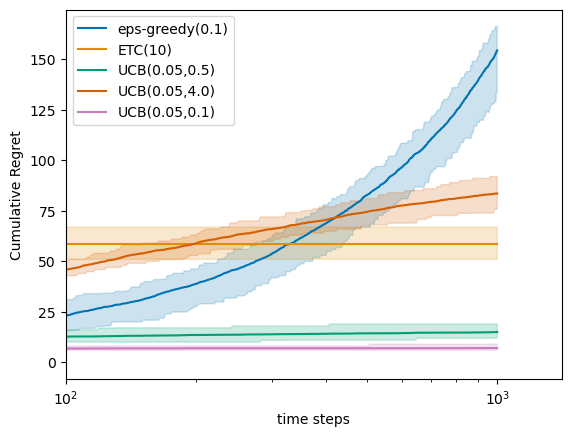

In [9]:
all_agents = experiment(small_var_GaussianBandit, [agent1, agent2, UCB_exact, badUCB, lowvarUCB], Nmc=50, T=1000)
plot_regret(all_agents, logscale=True)

### Conclusion:

Despite initially good-looking performance, epsilon-greedy has linear regret and becomes far worse than all other algorithms after t=200 or so. UCB's performance is not too badly affected by the variance input parameter, unless it is way too large (4.0 gives much worse regret). ETC has reliable performance but it suffers from a long exploration phase that is hard to tune to really be comparable to UCB. Overall UCB seems to be the best approach and it would be good to know how close to optimal is gets.

## Exercise 7.8 (Bandit book)

We reproduce Figure 7.1 from the bandit book, testing the value of the regret as a function of the minimum gap $\Delta$.

In [10]:
delta_vals = np.linspace(0.05,0.99,20)
K=2
T = 10**3
Nmc = 30
UCB_delta = UCB(K, var=1., delta=0.05, T=T)
ETC_25 = ETC(K,25)
ETC_50 = ETC(K,50)
ETC_75 = ETC(K,75)
ETC_100 = ETC(K,100)

agents = [UCB_delta, ETC_25, ETC_50, ETC_75, ETC_100]

delta_regrets = {}


for agent in agents:
  delta_regrets[agent.name()] = []
  for delta in delta_vals:
    means = np.array([0,-1 * delta])
    gaussianBandit = Bandit(means, var=1.)

    agent_id, regrets = play(gaussianBandit, agent, Nmc=Nmc, T=T)
    cum_regrets = np.sum(regrets,axis=1)
    avg_reg = np.mean(cum_regrets)
    delta_regrets[agent_id].append(avg_reg)

delta_regrets['ETC_exact'] = []
for delta in delta_vals:
  means = np.array([0,-1 * delta])
  gaussianBandit = Bandit(means, var=1.)
  exact_m = np.log(T * delta**2 /4) * 4 / delta**2
  exact_ETC = ETC(K,m=exact_m)

  _ , regrets = play(gaussianBandit, exact_ETC, Nmc=Nmc, T=T)
  cum_regrets = np.sum(regrets,axis=1)
  avg_reg = np.mean(cum_regrets)
  delta_regrets['ETC_exact'].append(avg_reg)



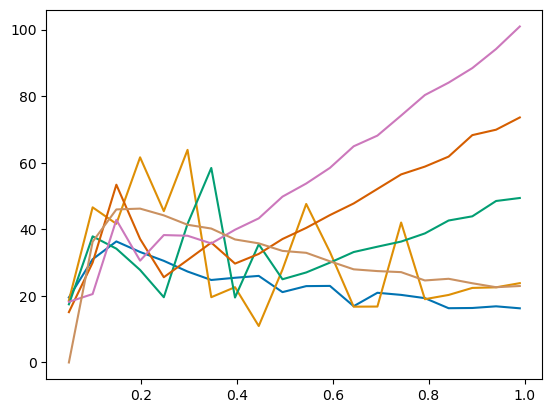

In [11]:
for i, agent_id in enumerate(delta_regrets.keys()):
  plt.plot(delta_vals, delta_regrets[agent_id], color=colors[i], label=agent_id)

## Asymptotic Optimality

In [12]:
class Asymp_UCB:
  def __init__(self, environment, var):
    self.K = environment.K
    self.var = var
    self.count_actions = np.zeros(self.K)
    self.count_rewards = np.zeros(self.K)
    self.t = 0

  def get_action(self):
    if self.t < self.K:
      action = self.t
      self.count_actions[action] += 1
      self.t += 1
    else:
      empirical_means = self.count_rewards / self.count_actions
      # ucbs_book = np.sqrt(2 * self.var * np.log(1+ self.t * np.log(self.t)**2) / self.count_actions)
      ucbs_cappe = np.sqrt(2 * self.var * (np.log(self.t)+ 3 * np.log(np.log(self.t))) / self.count_actions)
      # action = np.random.randint(0,high=self.K)
      # action = np.argmax(empirical_means + ucbs_book)
      action = np.argmax(empirical_means + ucbs_cappe)

      self.t += 1
      self.count_actions[action] += 1
    return action

  def receive_reward(self, action, reward):
    self.count_rewards[action] += reward

  def reset(self):
    self.count_actions = np.zeros(self.K)
    self.count_rewards = np.zeros(self.K)
    self.t = 0

  def name(self):
    return 'opt-UCB'

In [13]:
means = np.array([0., 1., 2., 3.])
basicGaussianBandit = Bandit(means)
T=10**4

UCB_delta = UCB(basicGaussianBandit,var=1.,delta=0.05,T=T)
UCB_asymp = Asymp_UCB(basicGaussianBandit,var=1.)

ucbs_comp = experiment(basicGaussianBandit, [UCB_delta,UCB_asymp], Nmc=50, T=T)
plot_regret(ucbs_comp)

TypeError: expected a sequence of integers or a single integer, got '<__main__.Bandit object at 0x167e49940>'

## Step 4: Your experimental benchmark

To validate all the theorems seen in class, it remains to code and test a few policies:
* Implement Explore-Then-Commit and compare it to espilon-greedy
* Implement UCB (pay attention to input parameters) and compare it to Explore-Then-Commit and Epsilon-Greedy


## Step 5: Optimality check

As seen in class, there is a theoretical way to check that a policy is (close to) optimal: compare its regret with the (problem-dependent) lower bound.

In [14]:
def LB(environment, T):
    means = environment.means # the LB is NOT a policy, it is an information-theoretic quantity
    var = environment.var
    gaps = np.max(means) - means
    nonzero_gaps = gaps[gaps>0.]
    # compute the Gaussian LB:
    lb_coeff = np.sum([2*var/gap for gap in nonzero_gaps])
    return lb_coeff*np.log(np.arange(T)+1)

In [15]:
LB = LB(basicGaussianBandit, 1000)

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_19635/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


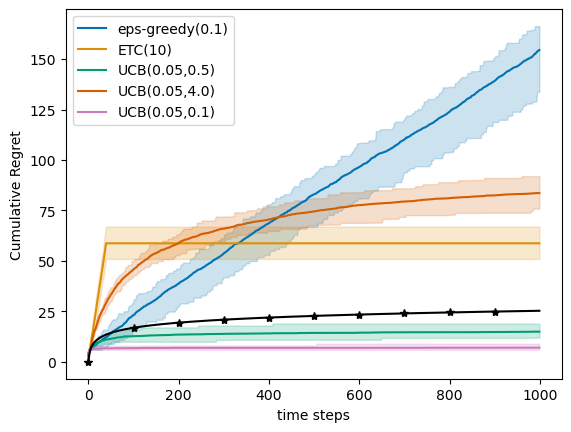

In [16]:
plot_regret(all_agents, lb=LB)

### Remark:
UCB does seem close to optimal... it'd be nice to see it more clearly though. Try the log-scale option of the plot function and run the experiment on a longer horizon (the lower bound is asymptotic!)

### Conclusions

What do you think ? Please write your conclusions about the optimality of UCB.

UCB is near optimal.